# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pathlib import Path # better file paths
from pyspark.sql.window import Window
from pyspark.sql.functions import countDistinct, col, when, lit, count, sum
from pyspark.sql.functions import round as sparkround
from pyspark.sql.functions import max as sparkMax #https://stackoverflow.com/questions/36924873/pyspark-column-is-not-iterable
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler # create numeric features
from pyspark.ml.feature import StringIndexer # convert Categorical variables to numeric Indexes
from pyspark.ml.feature import OneHotEncoderEstimator # one hot code categorical variables
from pyspark.ml import Pipeline # create a pipeline for different stages of preprocessing the data
from pyspark.ml.classification import LogisticRegression # a good starter algorithm for classification
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator # hyper parameter tuning and regular validation and CV
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator #needed to get F1 score
import pandas as pd 

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName('Sparkify') \
    .getOrCreate()
spark

In [3]:
# what is the project folder?
import os; os.getcwd()

'/Users/jas/github/udacity-data-scientist-nanodegree-capstone-project'

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# reading in data from local data folder which is gitignored due to large file size
event_data = Path.cwd() / "data" / "mini_sparkify_event_data.json"
df = spark.read.json(str(event_data))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
type(df)

pyspark.sql.dataframe.DataFrame

In [6]:
print(df.columns) # this way prints horizontally

['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']


In [7]:
df.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## Define Churn

* What column has Cancellation Confirmation? page?

In [8]:
df.groupby('page').count().sort('count', ascending=False).limit(50).toPandas()

,page,count
0,NextSong,228108
1,Home,14457
2,Thumbs Up,12551
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Login,3241
7,Logout,3226
8,Thumbs Down,2546
9,Downgrade,2055


* How many total rows (in this sample dataset)?

In [9]:
num_rows = df.count()
num_rows

286500

* How many total users?

In [10]:
#num_users = df.select(countDistinct("userId")).toPandas().values[0]
num_users = df.select(countDistinct("userId")).toPandas().iloc[0][0]
num_users

226

In [11]:
num_users_cancelled = df.filter('page == "Cancellation Confirmation"').select(countDistinct("userId")).toPandas().iloc[0][0]
num_users_cancelled

52

In [12]:
round(num_users_cancelled/num_users * 100, 1) # percentage of users that cancelled

23.0

In [13]:
# actually update the data with churn value

* Just need to find the ids that churned and of course the rest are not churned

In [14]:
cancelled_ids = df.filter('page == "Cancellation Confirmation"').select("userId").distinct()
# Convert to list to be used to filter later
cancelled_ids = cancelled_ids.toPandas()['userId'].tolist()
cancelled_ids[:5]

['125', '51', '54', '100014', '101']

* When the userId matches a cancelled user than we provide a value of **1**, else it is **0**.

In [15]:
len(cancelled_ids)

52

In [16]:
df = df.withColumn("Churn", when((col("userId").isin(cancelled_ids)),lit('1')).otherwise(lit('0')))
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    L

In [17]:
df.groupby('Churn').agg(countDistinct("userId")).toPandas()

,Churn,count(DISTINCT userId)
0,0,174
1,1,52


## Explore Data

### How many columns and what type of data?

In [18]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Churn: string (nullable = false)



In [19]:
## Descriptive stats
df.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,Churn
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.11718197783722,None,None,None,None,1.535358834085557E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104714E12,None,59682.02278593872,0.1565933682373473
2,stddev,1217.7693079161374,None,None,None,129.76726201141085,None,99.23517921058324,None,None,None,None,3.291321616328068E9,726.7762634630834,NaN,31.50507848842202,1.5075439608187113E9,None,109091.94999910519,0.3634175920988577
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",,0
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99,1


## artist

* Who are the most popular artists?

In [20]:
df.groupby('artist').count().sort('count', ascending=False).limit(5).toPandas() 

,artist,count
0,None,58392
1,Kings Of Leon,1841
2,Coldplay,1813
3,Florence + The Machine,1236
4,Dwight Yoakam,1135


## auth

In [21]:
df.groupby('auth').count().sort('count', ascending=False).limit(5).toPandas() 

,auth,count
0,Logged In,278102
1,Logged Out,8249
2,Guest,97
3,Cancelled,52


## Create a function to do the same thing for each column

In [22]:
def topn_values(column_name, n):
    """
    Take a column name and find the most frequent values
    """
    return df.groupby(column_name).count().sort('count', ascending=False).limit(n).toPandas()

In [23]:
for column in df.columns:
    top_values = topn_values(column, 5)
    print(top_values, "\n")

artist  count
0                    None  58392
1           Kings Of Leon   1841
2                Coldplay   1813
3  Florence + The Machine   1236
4           Dwight Yoakam   1135 

         auth   count
0   Logged In  278102
1  Logged Out    8249
2       Guest      97
3   Cancelled      52 

  firstName  count
0    Payton   9632
1      None   8346
2     Riley   7970
3    Lucero   6880
4    Emilia   5732 

  gender   count
0      F  154578
1      M  123576
2   None    8346 

   itemInSession  count
0              0   3278
1              1   3125
2              2   3067
3              3   3013
4              4   2977 

   lastName  count
0  Campbell  14060
1      Reed   9284
2  Williams   8410
3      None   8346
4    Taylor   7230 

      length  count
0        NaN  58392
1  239.30730   1205
2  348.57751   1037
3  201.79546    908
4  655.77751    730 

  level   count
0  paid  228162
1  free   58338 

                                location  count
0     Los Angeles-Long Beach-Anaheim, C

### Findings
* Need to ignore users without a **userId**, since we can't aggregate their data across sessions, or maybe there are only a few hits within a session that are missing and in that case we can fill the data

* Need to exclude information that is not relevant for modeling such as first and last name, userId is all we need for now 

* How many user agents per user? Can we seperate out browser and OS?

* Can we extract the user's state from the location to create a new variable with less cardinality?

## Page

* Need to see more than 5 pages

In [24]:
topn_values('page', 20)

,page,count
0,NextSong,228108
1,Home,14457
2,Thumbs Up,12551
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Login,3241
7,Logout,3226
8,Thumbs Down,2546
9,Downgrade,2055


## User agent

In [25]:
topn_values('userAgent', 20)

,userAgent,count
0,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",22751
1,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",19611
2,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18448
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",17348
4,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,16700
5,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",15395
6,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",14598
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,10300
8,"""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",8912
9,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,8624


In [26]:
#https://stackoverflow.com/questions/17805464/using-regex-to-retrieve-browser-name

In [27]:
df.filter('LOWER(userAgent) rlike "(firefox|msie|chrome|safari)"').toPandas()['userAgent'].head().to_csv(sys.stdout) #https://stackoverflow.com/questions/29902714/print-very-long-string-completely-in-pandas-dataframe

,userAgent
0,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0
1,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"""
2,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0
3,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"""
4,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0


## Gender

* gender - we expect each user to have 1 value

In [28]:
df.groupBy('userId')\
.agg(countDistinct("gender"))\
.withColumnRenamed("count(DISTINCT gender)", 'gender_count')\
.filter('gender_count != 1').show()

+------+------------+
|userId|gender_count|
+------+------------+
|      |           0|
+------+------------+



* Is there a large difference between genders?

In [29]:
gender_tab = df.crosstab('Churn', 'Gender').toPandas()
gender_tab

,Churn_Gender,F,M,null
0,1,19168,25696,0
1,0,135410,97880,8346


In [30]:
gender_tab['F']

0     19168
1    135410
Name: F, dtype: int64

In [31]:
# Toy example

In [32]:
import plotly.express as px
df3 = px.data.tips()
df3.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [33]:

fig = px.bar(df3, y = "day", x="total_bill", color = "sex", title='Bar Chart' )
fig.show()

* Transform gender crosstab data from wide to long

In [34]:
fig = px.bar(df3,x="total_bill",  y = "day",  color = "sex", title='Bar Chart' )
fig.show()

In [35]:
# A better toy example
import plotly.graph_objects as go
animals=['giraffes', 'orangutans', 'monkeys']

fig = go.Figure(data=[
    go.Bar(name='SF Zoo', x=animals, y=[20, 14, 23]),
    go.Bar(name='LA Zoo', x=animals, y=[12, 18, 29])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

### Gender

In [36]:
churn = ['1', '0']

fig = go.Figure(data=[
    go.Bar(name='Male', x=churn, y=gender_tab['M']),
    go.Bar(name='Female', x=churn, y=gender_tab['F']),
    go.Bar(name='Other', x=churn, y=gender_tab['null'])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

* Appears as though men disproportionately cancel more than women

* Wait a minute... data has not yet been aggregated to the user level

# Transform data to user level

## Feature engineering here as well mixed in

* how many unique artists did they listen to?
* how many unique songs? maybe churned users listened to less songs and were less active?
* how many unique sessions per user?
* how many 404 errors (not found)? Maybe frustrated users churned because they got too many errors?
* 307s are also a type of error
* Level - Since paid (p) is alphabetically higher than free (f), if we do max we will capture anyone who ever transitioned from free to paid, and of course if they were still free it will stay free

In [37]:
exprs = [\
   sparkMax(col('churn')).alias('churn')\
  ,sparkMax(col('Gender')).alias('gender')\
  ,sparkMax(col('level')).alias('subscription_level')\
  ,sparkMax(when(col("page") == 'Upgrade', 1).otherwise(0)).alias('page_upgraded')
  ,sparkMax(when(col("page") == 'Downgrade', 1).otherwise(0)).alias('page_downgraded')
  ,count(when(col("auth") == 'Logged In', True)).alias('auth_logged_in_cnt')\
  ,count(when(col("auth") == 'Logged Out', True)).alias('auth_logged_out_cnt')\
  ,count(when(col("auth") == 'Guest', True)).alias('auth_guest_cnt')\
  ,count(when(col("status") == '404', True)).alias('status_404_cnt')\
  ,count(when(col("status") == '307', True)).alias('status_307_cnt')\
  ,count(when(col("page") == 'Next Song', True)).alias('page_next_song_cnt')
  ,count(when(col("page") == 'Thumbs Up', True)).alias('page_thumbs_up_cnt')
  ,count(when(col("page") == 'Thumbs Down', True)).alias('page_thumbs_down_cnt')
  ,count(when(col("page") == 'Add to Playlist', True)).alias('page_playlist_cnt')
  ,count(when(col("page") == 'Add Friend', True)).alias('page_friend_cnt')
  ,count(when(col("page") == 'Roll Advert', True)).alias('page_roll_ad_cnt')
  ,count(when(col("page") == 'Logout', True)).alias('page_logout_cnt')
  ,count(when(col("page") == 'Help', True)).alias('page_help_cnt')
  ,countDistinct('artist').alias('artist_cnt')\
  ,countDistinct('song').alias('song_cnt')\
  ,countDistinct('sessionId').alias('session_cnt')\
]

user_df = df.groupBy('userId')\
.agg(*exprs)

# Should have already removed rows with no userIds earlier
# Remove data with null values - needs to be added to pipeline
user_df = user_df.where(col("gender").isNotNull()) #only 1 value is null and can't assume a value on a heuristic

user_df.toPandas().head()

,userId,churn,gender,subscription_level,page_upgraded,page_downgraded,auth_logged_in_cnt,auth_logged_out_cnt,auth_guest_cnt,status_404_cnt,...,page_thumbs_up_cnt,page_thumbs_down_cnt,page_playlist_cnt,page_friend_cnt,page_roll_ad_cnt,page_logout_cnt,page_help_cnt,artist_cnt,song_cnt,session_cnt
0,100010,0,F,free,1,0,381,0,0,0,...,17,5,7,4,52,5,2,252,269,7
1,200002,0,M,paid,1,1,474,0,0,0,...,21,6,8,4,7,5,2,339,378,6
2,125,1,M,free,0,0,10,0,0,0,...,0,0,0,0,1,0,0,8,8,1
3,124,0,F,paid,0,1,4825,0,0,6,...,171,41,118,74,4,59,23,2232,3339,29
4,51,1,M,paid,0,1,2463,0,0,1,...,100,21,52,28,0,24,12,1385,1854,10


In [37]:
user_df.count() # same as original userId count near top 

225

### How unbalanced is the dataset?

In [38]:
user_count = user_df.groupby('churn').count()
user_count = user_count.withColumn('percent', col('count')/sum('count').over(Window.partitionBy()))
# multiply by 100 and round
user_count = user_count.withColumn("percent", sparkround(user_count["percent"] * 100, 2))
user_count.orderBy('percent', ascending=False).show()

+-----+-----+-------+
|churn|count|percent|
+-----+-----+-------+
|    0|  173|  76.89|
|    1|   52|  23.11|
+-----+-----+-------+



In [39]:
user_df.where(col("userId").isNull()).show() # we are going to ignore users without a userId since we can't aggregate

+------+-----+------+------------------+-------------+---------------+------------------+-------------------+--------------+--------------+--------------+------------------+------------------+--------------------+-----------------+---------------+----------------+---------------+-------------+----------+--------+-----------+
|userId|churn|gender|subscription_level|page_upgraded|page_downgraded|auth_logged_in_cnt|auth_logged_out_cnt|auth_guest_cnt|status_404_cnt|status_307_cnt|page_next_song_cnt|page_thumbs_up_cnt|page_thumbs_down_cnt|page_playlist_cnt|page_friend_cnt|page_roll_ad_cnt|page_logout_cnt|page_help_cnt|artist_cnt|song_cnt|session_cnt|
+------+-----+------+------------------+-------------+---------------+------------------+-------------------+--------------+--------------+--------------+------------------+------------------+--------------------+-----------------+---------------+----------------+---------------+-------------+----------+--------+-----------+
+------+-----+-----

In [40]:
### rename columns (don't need to anymore)
#newcolnames = ['userId', 'gender', 'churn']
# for c, n in zip(user_df.columns, newcolnames): #https://stackoverflow.com/questions/34077353/how-to-change-dataframe-column-names-in-pyspark
#     user_df = user_df.withColumnRenamed(c, n)
#user_df.columns 

In [41]:
user_df.show()

+------+-----+------+------------------+-------------+---------------+------------------+-------------------+--------------+--------------+--------------+------------------+------------------+--------------------+-----------------+---------------+----------------+---------------+-------------+----------+--------+-----------+
|userId|churn|gender|subscription_level|page_upgraded|page_downgraded|auth_logged_in_cnt|auth_logged_out_cnt|auth_guest_cnt|status_404_cnt|status_307_cnt|page_next_song_cnt|page_thumbs_up_cnt|page_thumbs_down_cnt|page_playlist_cnt|page_friend_cnt|page_roll_ad_cnt|page_logout_cnt|page_help_cnt|artist_cnt|song_cnt|session_cnt|
+------+-----+------+------------------+-------------+---------------+------------------+-------------------+--------------+--------------+--------------+------------------+------------------+--------------------+-----------------+---------------+----------------+---------------+-------------+----------+--------+-----------+
|100010|    0|     

In [42]:
user_df.filter('auth_Guest_cnt != 0').show()

+------+-----+------+------------------+-------------+---------------+------------------+-------------------+--------------+--------------+--------------+------------------+------------------+--------------------+-----------------+---------------+----------------+---------------+-------------+----------+--------+-----------+
|userId|churn|gender|subscription_level|page_upgraded|page_downgraded|auth_logged_in_cnt|auth_logged_out_cnt|auth_guest_cnt|status_404_cnt|status_307_cnt|page_next_song_cnt|page_thumbs_up_cnt|page_thumbs_down_cnt|page_playlist_cnt|page_friend_cnt|page_roll_ad_cnt|page_logout_cnt|page_help_cnt|artist_cnt|song_cnt|session_cnt|
+------+-----+------+------------------+-------------+---------------+------------------+-------------------+--------------+--------------+--------------+------------------+------------------+--------------------+-----------------+---------------+----------------+---------------+-------------+----------+--------+-----------+
+------+-----+-----

* Okay it appears that when a user logs out we don't see there associated userId, so this data cannot be used.. also need need to remove this NULL or empty user Id

# EDA Visualizations continued...

In [43]:
gender_tab = user_df.crosstab('churn', 'gender').toPandas()

churn = ['1', '0']

fig = go.Figure(data=[
    go.Bar(name='Male', x=churn, y=gender_tab['M'])
    ,go.Bar(name='Female', x=churn, y=gender_tab['F'])
    #,go.Bar(name='Other', x=churn, y=gender_tab['null'])
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

### Subscription level

In [47]:
user_df.crosstab('churn', 'subscription_level').toPandas()


,churn_subscription_level,free,paid
0,1,16,36
1,0,44,129


In [48]:
subscription_level_tab = user_df.crosstab('churn', 'subscription_level').toPandas()

churn = ['1', '0']

fig = go.Figure(data=[
    go.Bar(name='free', x=churn, y=subscription_level_tab['free']),
    go.Bar(name='paid', x=churn, y=subscription_level_tab['paid']),
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

* appears a larger proportion of free churned vs non churned users (0)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Correlation Analysis

* Are any of the current variables highly correlated?

In [46]:
# toy example
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

data = [(Vectors.sparse(4, [(0, 1.0), (3, -2.0)]),),
        (Vectors.dense([4.0, 5.0, 0.0, 3.0]),),
        (Vectors.dense([6.0, 7.0, 0.0, 8.0]),),
        (Vectors.sparse(4, [(0, 9.0), (3, 1.0)]),)]
df = spark.createDataFrame(data, ["features"])

r1 = Correlation.corr(df, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

r2 = Correlation.corr(df, "features", "spearman").head()
print("Spearman correlation matrix:\n" + str(r2[0]))

Pearson correlation matrix:
DenseMatrix([[1.        , 0.05564149,        nan, 0.40047142],
             [0.05564149, 1.        ,        nan, 0.91359586],
             [       nan,        nan, 1.        ,        nan],
             [0.40047142, 0.91359586,        nan, 1.        ]])
Spearman correlation matrix:
DenseMatrix([[1.        , 0.10540926,        nan, 0.4       ],
             [0.10540926, 1.        ,        nan, 0.9486833 ],
             [       nan,        nan, 1.        ,        nan],
             [0.4       , 0.9486833 ,        nan, 1.        ]])


In [46]:
df.head()

Row(features=SparseVector(4, {0: 1.0, 3: -2.0}))

## Convert categorical variables to stringIndex

* Need to do this on a list of categorical variables later in a pipeline

In [49]:
user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- subscription_level: string (nullable = true)
 |-- page_upgraded: integer (nullable = true)
 |-- page_downgraded: integer (nullable = true)
 |-- auth_logged_in_cnt: long (nullable = false)
 |-- auth_logged_out_cnt: long (nullable = false)
 |-- auth_guest_cnt: long (nullable = false)
 |-- status_404_cnt: long (nullable = false)
 |-- status_307_cnt: long (nullable = false)
 |-- page_next_song_cnt: long (nullable = false)
 |-- page_thumbs_up_cnt: long (nullable = false)
 |-- page_thumbs_down_cnt: long (nullable = false)
 |-- page_playlist_cnt: long (nullable = false)
 |-- page_friend_cnt: long (nullable = false)
 |-- page_roll_ad_cnt: long (nullable = false)
 |-- page_logout_cnt: long (nullable = false)
 |-- page_help_cnt: long (nullable = false)
 |-- artist_cnt: long (nullable = false)
 |-- song_cnt: long (nullable = false)
 |-- session_cnt: long (nullable = false)



In [50]:
user_df.groupBy("gender").count().show() # Only 1 null so dropped it

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



In [51]:
user_df.groupBy("subscription_level").count().show()

+------------------+-----+
|subscription_level|count|
+------------------+-----+
|              free|   60|
|              paid|  165|
+------------------+-----+



* need to do it one categorical variable at a time for now

In [52]:
indexer = StringIndexer(inputCol="gender", outputCol="gender_Index")
model_df = indexer.fit(user_df).transform(user_df)
model_df.select(["gender","gender_Index"]).show(5)

+------+------------+
|gender|gender_Index|
+------+------------+
|     F|         1.0|
|     M|         0.0|
|     M|         0.0|
|     F|         1.0|
|     M|         0.0|
+------+------------+
only showing top 5 rows



In [53]:
indexer = StringIndexer(inputCol="subscription_level", outputCol="subscription_level_Index")
model_df = indexer.fit(model_df).transform(model_df)
model_df.select(["subscription_level","subscription_level_Index"]).show(5)

+------------------+------------------------+
|subscription_level|subscription_level_Index|
+------------------+------------------------+
|              free|                     1.0|
|              paid|                     0.0|
|              free|                     1.0|
|              paid|                     0.0|
|              paid|                     0.0|
+------------------+------------------------+
only showing top 5 rows



## One hot code categorical features

In [54]:
encoder = OneHotEncoderEstimator(inputCols=["gender_Index", "subscription_level_Index"],
                                 outputCols=["gender_Vec", "subscription_level_Vec"])
model_df = encoder.fit(model_df).transform(model_df)
model_df.select(["gender","gender_Index","gender_Vec","subscription_level","subscription_level_Index","subscription_level_Vec"]).show(5)

+------+------------+-------------+------------------+------------------------+----------------------+
|gender|gender_Index|   gender_Vec|subscription_level|subscription_level_Index|subscription_level_Vec|
+------+------------+-------------+------------------+------------------------+----------------------+
|     F|         1.0|    (1,[],[])|              free|                     1.0|             (1,[],[])|
|     M|         0.0|(1,[0],[1.0])|              paid|                     0.0|         (1,[0],[1.0])|
|     M|         0.0|(1,[0],[1.0])|              free|                     1.0|             (1,[],[])|
|     F|         1.0|    (1,[],[])|              paid|                     0.0|         (1,[0],[1.0])|
|     M|         0.0|(1,[0],[1.0])|              paid|                     0.0|         (1,[0],[1.0])|
+------+------------+-------------+------------------+------------------------+----------------------+
only showing top 5 rows



## Create numeric features

In [55]:
print(model_df.columns)

['userId', 'churn', 'gender', 'subscription_level', 'page_upgraded', 'page_downgraded', 'auth_logged_in_cnt', 'auth_logged_out_cnt', 'auth_guest_cnt', 'status_404_cnt', 'status_307_cnt', 'page_next_song_cnt', 'page_thumbs_up_cnt', 'page_thumbs_down_cnt', 'page_playlist_cnt', 'page_friend_cnt', 'page_roll_ad_cnt', 'page_logout_cnt', 'page_help_cnt', 'artist_cnt', 'song_cnt', 'session_cnt', 'gender_Index', 'subscription_level_Index', 'gender_Vec', 'subscription_level_Vec']


In [56]:
numeric_columns = ['auth_logged_in_cnt', 'auth_guest_cnt', 'status_404_cnt', 'page_next_song_cnt']

In [57]:
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="NumericFeatures")
model_df = assembler.transform(model_df)
model_df.head()
model_df.select("NumericFeatures", "churn").show(truncate=False)

+--------------------+-----+
|NumericFeatures     |churn|
+--------------------+-----+
|(4,[0],[381.0])     |0    |
|(4,[0],[474.0])     |0    |
|(4,[0],[10.0])      |1    |
|[4825.0,0.0,6.0,0.0]|0    |
|[2463.0,0.0,1.0,0.0]|1    |
|[201.0,0.0,1.0,0.0] |0    |
|[2278.0,0.0,2.0,0.0]|0    |
|[3436.0,0.0,1.0,0.0]|1    |
|[1002.0,0.0,3.0,0.0]|0    |
|(4,[0],[309.0])     |1    |
|[2304.0,0.0,3.0,0.0]|0    |
|(4,[0],[118.0])     |0    |
|[2148.0,0.0,3.0,0.0]|1    |
|[848.0,0.0,1.0,0.0] |0    |
|[2469.0,0.0,1.0,0.0]|0    |
|[4428.0,0.0,5.0,0.0]|0    |
|[318.0,0.0,2.0,0.0] |1    |
|(4,[0],[3602.0])    |1    |
|[1342.0,0.0,4.0,0.0]|0    |
|(4,[0],[292.0])     |0    |
+--------------------+-----+
only showing top 20 rows



In [58]:
from pyspark.ml.stat import Correlation
r1 = Correlation.corr(model_df, "NumericFeatures").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

Pearson correlation matrix:
DenseMatrix([[1.        ,        nan, 0.70411426,        nan],
             [       nan, 1.        ,        nan,        nan],
             [0.70411426,        nan, 1.        ,        nan],
             [       nan,        nan,        nan, 1.        ]])


## Normalize the numeric features

In [59]:
scaler = Normalizer(inputCol="NumericFeatures", outputCol="ScaledNumericFeatures")
model_df = scaler.transform(model_df)
model_df.head(2)

[Row(userId='100010', churn='0', gender='F', subscription_level='free', page_upgraded=1, page_downgraded=0, auth_logged_in_cnt=381, auth_logged_out_cnt=0, auth_guest_cnt=0, status_404_cnt=0, status_307_cnt=31, page_next_song_cnt=0, page_thumbs_up_cnt=17, page_thumbs_down_cnt=5, page_playlist_cnt=7, page_friend_cnt=4, page_roll_ad_cnt=52, page_logout_cnt=5, page_help_cnt=2, artist_cnt=252, song_cnt=269, session_cnt=7, gender_Index=1.0, subscription_level_Index=1.0, gender_Vec=SparseVector(1, {}), subscription_level_Vec=SparseVector(1, {}), NumericFeatures=SparseVector(4, {0: 381.0}), ScaledNumericFeatures=SparseVector(4, {0: 1.0})),
 Row(userId='200002', churn='0', gender='M', subscription_level='paid', page_upgraded=1, page_downgraded=1, auth_logged_in_cnt=474, auth_logged_out_cnt=0, auth_guest_cnt=0, status_404_cnt=0, status_307_cnt=37, page_next_song_cnt=0, page_thumbs_up_cnt=21, page_thumbs_down_cnt=6, page_playlist_cnt=8, page_friend_cnt=4, page_roll_ad_cnt=7, page_logout_cnt=5, pa

In [60]:
model_df.select("ScaledNumericFeatures", "churn").show()

+---------------------+-----+
|ScaledNumericFeatures|churn|
+---------------------+-----+
|        (4,[0],[1.0])|    0|
|        (4,[0],[1.0])|    0|
|        (4,[0],[1.0])|    1|
| [0.99999922682577...|    0|
| [0.99999991757838...|    1|
| [0.99998762429845...|    0|
| [0.99999961459059...|    0|
| [0.99999995764900...|    1|
| [0.99999551797627...|    0|
|        (4,[0],[1.0])|    1|
| [0.99999915229057...|    0|
|        (4,[0],[1.0])|    0|
| [0.99999902468854...|    1|
| [0.99999930469100...|    0|
| [0.99999991797848...|    0|
| [0.99999936247917...|    0|
| [0.99998022288804...|    1|
|        (4,[0],[1.0])|    1|
| [0.99999555796412...|    0|
|        (4,[0],[1.0])|    0|
+---------------------+-----+
only showing top 20 rows



* Combine the categorical variables from earlier..

In [61]:
numeric_columns = ['auth_logged_in_cnt', 'auth_guest_cnt', 'status_404_cnt', 'page_next_song_cnt']
categorical = ['gender_Vec','subscription_level_Vec'] # TO DO: can convert to a for loop or anonymous function
all_columns = ['ScaledNumericFeatures'] + categorical

In [62]:
assembler = VectorAssembler(inputCols=all_columns, outputCol="AllFeatures")
model_df = assembler.transform(model_df)
model_df.select("AllFeatures", "churn").show(truncate=False)

+----------------------------------------------------------+-----+
|AllFeatures                                               |churn|
+----------------------------------------------------------+-----+
|(6,[0],[1.0])                                             |0    |
|[1.0,0.0,0.0,0.0,1.0,1.0]                                 |0    |
|(6,[0,4],[1.0,1.0])                                       |1    |
|[0.9999992268257778,0.0,0.0012435223546020035,0.0,0.0,1.0]|0    |
|[0.9999999175783836,0.0,4.0600889873259585E-4,0.0,1.0,1.0]|1    |
|[0.999987624298452,0.0,0.004975062807454985,0.0,1.0,0.0]  |0    |
|[0.9999996145905978,0.0,8.779627871734835E-4,0.0,1.0,1.0] |0    |
|[0.9999999576490003,0.0,2.910360761493016E-4,0.0,0.0,1.0] |1    |
|[0.9999955179762766,0.0,0.0029939985568151993,0.0,0.0,1.0]|0    |
|[1.0,0.0,0.0,0.0,1.0,1.0]                                 |1    |
|[0.9999991522905743,0.0,0.0013020822295450186,0.0,0.0,1.0]|0    |
|(6,[0],[1.0])                                             |0 

## Pipeline

* Put it all together in a clean pipeline

In [63]:
numeric_columns = ['auth_logged_in_cnt', 'auth_guest_cnt', 'status_404_cnt', 'page_next_song_cnt']
categorical = ['gender_Vec','subscription_level_Vec'] # TO DO: can convert to a for loop or anonymous function
all_columns = ['ScaledNumericFeatures'] + categorical
print(all_columns)

['ScaledNumericFeatures', 'gender_Vec', 'subscription_level_Vec']


In [80]:
assembler_numeric = VectorAssembler(inputCols=numeric_columns, outputCol="NumericFeatures")
scaler = Normalizer(inputCol="NumericFeatures", outputCol="ScaledNumericFeatures")
# Maybe this can be done in parallel like in sci-kit learn?
indexer_gender = StringIndexer(inputCol="gender", outputCol="gender_Index")
indexer_subscription_level = StringIndexer(inputCol="subscription_level", outputCol="subscription_level_Index")
encoder_onehot = OneHotEncoderEstimator(inputCols=["gender_Index", "subscription_level_Index"],
                                 outputCols=["gender_Vec", "subscription_level_Vec"])
assembler_all = VectorAssembler(inputCols=all_columns, outputCol="features") # churn already specified as label
indexer_churn = StringIndexer(inputCol="churn", outputCol="label") #cast from string to numeric and must be named label - could be problematic
lr = LogisticRegression(maxIter=10)

In [81]:
pipeline = Pipeline(stages=[assembler_numeric, scaler, indexer_gender, indexer_subscription_level, encoder_onehot, assembler_all,indexer_churn, lr])
pipeline

Pipeline_92ab41fc1de6

In [82]:
model = pipeline.fit(user_df)
model

PipelineModel_f5845642d633

* Took a few mins

* Predict on same dataset for now

In [83]:
prediction = model.transform(user_df)
result = prediction.select("features", "label", "probability", "rawPrediction") \
    .collect()

for row in result:
    print("features=%s, label=%s -> prob=%s, prediction=%s"
          % (row.features, row.label, row.probability, row.rawPrediction))

937713]
features=[0.9999983531056722,0.0,0.0018148790437489512,0.0,1.0,1.0], label=1.0 -> prob=[0.7688878651751514,0.23111213482484866], prediction=[1.2020421149750797,-1.2020421149750797]
features=(6,[0,5],[1.0,1.0]), label=0.0 -> prob=[0.768887865186432,0.23111213481356788], prediction=[1.2020421150385618,-1.2020421150385618]
features=[0.9999998985472113,0.0,0.00045045040475099604,0.0,0.0,1.0], label=0.0 -> prob=[0.7688878651894245,0.23111213481057555], prediction=[1.2020421150554015,-1.2020421150554015]
features=[0.9999877465246075,0.0,0.004950434388735681,0.0,1.0,0.0], label=0.0 -> prob=[0.7688878651895832,0.2311121348104168], prediction=[1.2020421150562948,-1.2020421150562948]
features=[0.9999979090149682,0.0,0.0020449854990081152,0.0,1.0,1.0], label=0.0 -> prob=[0.7688878651770815,0.2311121348229184], prediction=[1.202042114985942,-1.202042114985942]
features=[0.9999988883813183,0.0,0.0014910520204492817,0.0,0.0,1.0], label=0.0 -> prob=[0.7688878651971315,0.23111213480286852], pr

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [84]:
### baseline model for comparison

In [85]:
user_df

DataFrame[userId: string, churn: string, gender: string, subscription_level: string, page_upgraded: int, page_downgraded: int, auth_logged_in_cnt: bigint, auth_logged_out_cnt: bigint, auth_guest_cnt: bigint, status_404_cnt: bigint, status_307_cnt: bigint, page_next_song_cnt: bigint, page_thumbs_up_cnt: bigint, page_thumbs_down_cnt: bigint, page_playlist_cnt: bigint, page_friend_cnt: bigint, page_roll_ad_cnt: bigint, page_logout_cnt: bigint, page_help_cnt: bigint, artist_cnt: bigint, song_cnt: bigint, session_cnt: bigint]

In [86]:
train, test = user_df.randomSplit([0.9, 0.1], seed=12345)
# test in this case is the same as holdout set

In [87]:
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01])\
    .build()
paramGrid

[{Param(parent='LogisticRegression_592d2f8344aa', name='regParam', doc='regularization parameter (>= 0).'): 0.1},
 {Param(parent='LogisticRegression_592d2f8344aa', name='regParam', doc='regularization parameter (>= 0).'): 0.01}]

In [88]:
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=MulticlassClassificationEvaluator( metricName='f1'),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)
tvs

TrainValidationSplit_dba53911de1d

In [90]:
# Run TrainValidationSplit, and choose the best set of parameters.
tvs_model = tvs.fit(train)
tvs_model


TrainValidationSplitModel_943f44d5c1ec

In [91]:
tvs_model.bestModel

PipelineModel_334b9393028a

In [92]:
tvs_model.explainParams()

"estimator: estimator to be cross-validated (current: Pipeline_92ab41fc1de6)\nestimatorParamMaps: estimator param maps (current: [{Param(parent='LogisticRegression_592d2f8344aa', name='regParam', doc='regularization parameter (>= 0).'): 0.1}, {Param(parent='LogisticRegression_592d2f8344aa', name='regParam', doc='regularization parameter (>= 0).'): 0.01}])\nevaluator: evaluator used to select hyper-parameters that maximize the validator metric (current: MulticlassClassificationEvaluator_942059c5dc85)\nseed: random seed. (default: -8243909112844880721)"

In [93]:
prediction = tvs_model.transform(test)
print(prediction.columns)

['userId', 'churn', 'gender', 'subscription_level', 'page_upgraded', 'page_downgraded', 'auth_logged_in_cnt', 'auth_logged_out_cnt', 'auth_guest_cnt', 'status_404_cnt', 'status_307_cnt', 'page_next_song_cnt', 'page_thumbs_up_cnt', 'page_thumbs_down_cnt', 'page_playlist_cnt', 'page_friend_cnt', 'page_roll_ad_cnt', 'page_logout_cnt', 'page_help_cnt', 'artist_cnt', 'song_cnt', 'session_cnt', 'NumericFeatures', 'ScaledNumericFeatures', 'gender_Index', 'subscription_level_Index', 'gender_Vec', 'subscription_level_Vec', 'features', 'label', 'rawPrediction', 'probability', 'prediction']


In [165]:
# Make predictions on test data. model is the model with combination of parameters
# that performed best.
selected = prediction.select("features", "label", "probability", "prediction")
for row in selected.collect():
    print(row)

 1.0, 1.0]), label=0.0, probability=DenseVector([0.7689, 0.2311]), prediction=0.0)
Row(features=DenseVector([1.0, 0.0, 0.001, 0.0, 0.0, 1.0]), label=0.0, probability=DenseVector([0.7689, 0.2311]), prediction=0.0)
Row(features=DenseVector([1.0, 0.0, 0.0006, 0.0, 1.0, 1.0]), label=0.0, probability=DenseVector([0.7689, 0.2311]), prediction=0.0)
Row(features=DenseVector([1.0, 0.0, 0.0021, 0.0, 1.0, 1.0]), label=0.0, probability=DenseVector([0.7689, 0.2311]), prediction=0.0)
Row(features=DenseVector([1.0, 0.0, 0.001, 0.0, 0.0, 1.0]), label=0.0, probability=DenseVector([0.7689, 0.2311]), prediction=0.0)
Row(features=SparseVector(6, {0: 1.0, 5: 1.0}), label=1.0, probability=DenseVector([0.7689, 0.2311]), prediction=0.0)
Row(features=SparseVector(6, {0: 1.0, 5: 1.0}), label=1.0, probability=DenseVector([0.7689, 0.2311]), prediction=0.0)
Row(features=DenseVector([1.0, 0.0, 0.0, 0.0, 1.0, 1.0]), label=0.0, probability=DenseVector([0.7689, 0.2311]), prediction=0.0)
Row(features=DenseVector([1.0, 

In [166]:
### Export model to pickle file

In [94]:
tvs_model.bestModel.stages[-1]

LogisticRegressionModel: uid = LogisticRegression_592d2f8344aa, numClasses = 2, numFeatures = 6

In [95]:
tvs_model.bestModel.stages[-1].summary

In [96]:
# evaluate the model with test set
evaluator = MulticlassClassificationEvaluator() 
print('F1-Score ', evaluator.evaluate(prediction, 
                                      {evaluator.metricName: 'f1'}))
print('Precision ', evaluator.evaluate(prediction,
                                       {evaluator.metricName:                    'weightedPrecision'}))
print('Recall ', evaluator.evaluate(prediction, 
                                    {evaluator.metricName: 'weightedRecall'}))
print('Accuracy ', evaluator.evaluate(prediction, 
                                      {evaluator.metricName: 'accuracy'}))                  

F1-Score  0.6736596736596737
Precision  0.597107438016529
Recall  0.7727272727272727
Accuracy  0.7727272727272727


In [97]:
rf_auc = BinaryClassificationEvaluator().evaluate(prediction)
print('AUC ', rf_auc)      

AUC  0.6235294117647059


* Remember 0.5 AUC is the same as a model that has no predictive power and can be accomplished by chance

## Plot AUC as well

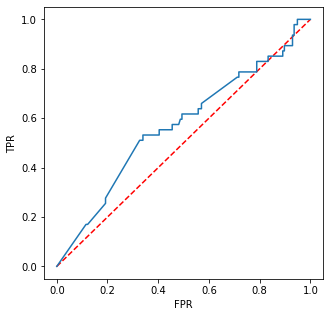

In [98]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(tvs_model.bestModel.stages[-1].summary.roc.select('FPR').collect(),
         tvs_model.bestModel.stages[-1].summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

### Save model

In [102]:
model_path = Path.cwd() / "models" / "june7_lr_model"
tvs_model.bestModel.write().overwrite().save(str(model_path))

### Load saved model

In [103]:
# read pickled model via pipeline api
from pyspark.ml.pipeline import PipelineModel
persistedModel = PipelineModel.load(str(model_path))
persistedModel

PipelineModel_334b9393028a

In [104]:
test.head(1)

[Row(userId='154', churn='0', gender='F', subscription_level='free', page_upgraded=0, page_downgraded=0, auth_logged_in_cnt=118, auth_logged_out_cnt=0, auth_guest_cnt=0, status_404_cnt=0, status_307_cnt=16, page_next_song_cnt=0, page_thumbs_up_cnt=11, page_thumbs_down_cnt=0, page_playlist_cnt=1, page_friend_cnt=3, page_roll_ad_cnt=10, page_logout_cnt=2, page_help_cnt=1, artist_cnt=78, song_cnt=83, session_cnt=3)]

### Simulate a user entering data and make prediction

In [105]:
# dictionary of lists 
dict = {
        'gender':["F"], 
        'subscription_level': ["free"], 
        'auth_logged_in_cnt': [11], 
        'auth_guest_cnt': [4], 
        'status_404_cnt': [6],     
        'page_next_song_cnt': [9]
}
test_df_pd = pd.DataFrame(dict) 
# convert to spark dataframe
test_df = spark.createDataFrame(test_df_pd)
test_df.show()

+------+------------------+------------------+--------------+--------------+------------------+
|gender|subscription_level|auth_logged_in_cnt|auth_guest_cnt|status_404_cnt|page_next_song_cnt|
+------+------------------+------------------+--------------+--------------+------------------+
|     F|              free|                11|             4|             6|                 9|
+------+------------------+------------------+--------------+--------------+------------------+



In [106]:
test_df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- subscription_level: string (nullable = true)
 |-- auth_logged_in_cnt: long (nullable = true)
 |-- auth_guest_cnt: long (nullable = true)
 |-- status_404_cnt: long (nullable = true)
 |-- page_next_song_cnt: long (nullable = true)



In [107]:
# predict
predictionsDF = persistedModel.transform(test_df)

In [108]:
predictionsDF.select("features", "probability", "prediction").show(truncate=False)

+---------------------------------------------------------------------------------------+---------------------------------------+----------+
|features                                                                               |probability                            |prediction|
+---------------------------------------------------------------------------------------+---------------------------------------+----------+
|[0.6902013856519744,0.25098232205526344,0.37647348308289513,0.5647102246243427,0.0,0.0]|[0.768472178253726,0.23152782174627398]|0.0       |
+---------------------------------------------------------------------------------------+---------------------------------------+----------+

